In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.signal import correlate
from scipy.stats import pearsonr

以下のセルでEKF_Simulation_AllData.csvにカラム名を付与してください

In [63]:
path = "data/AllData_takami_60s.csv"

In [64]:
column_names = [
    'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
    'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
    'u1_s', 'u2_s',  # s_uHistory
    'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
    'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
    'u1_l', 'u2_l'  # l_uHistory
]
df = pd.read_csv(path, names=column_names, header=None)

In [65]:
df.to_csv(path,index=False)

次に「use_makecop.m」を実行してcopを計算してください
次にdata\EKF_Simulation_AllData_with_COP.csvを使用してcomのデータを取得します

In [66]:
df = pd.read_csv("data/AllData_takami_60s_with_COP.csv")

system_params = {
    'm1': 28.00,   # Mass of the first segment (leg)
    'm2': 53.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.88,    # Length of the second segment (trunk)
    'com1': 0.58,  # Distance to CoM of the first segment
    'com2': 0.32,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Function to calculate CoM
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # Convert to radians
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # Calculate CoM positions
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    # Ensure it returns a Pandas Series with correct length
    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'],row['q2_s_true'], system_params), axis=1)
df[['com_x_l', 'com_z_l']] = df.apply(lambda row: calculate_com(row['q1_l_true'],row['q2_l_true'], system_params), axis=1)

df[['dcom_x_s', 'dcom_z_s']] = df[['com_x_s', 'com_z_s']].diff().fillna(0)
df[['dcom_x_l', 'dcom_z_l']] = df[['com_x_l', 'com_z_l']].diff().fillna(0)

df[['ddcom_x_s', 'ddcom_z_s']] = df[['dcom_x_s', 'dcom_z_s']].diff().fillna(0)
df[['ddcom_x_l', 'ddcom_z_l']] = df[['dcom_x_l', 'dcom_z_l']].diff().fillna(0)

df[['dCOP_s', 'dCOP_l']] = df[['COP_s', 'COP_l']].diff().fillna(0)
df[['ddCOP_s', 'ddCOP_l']] = df[['dCOP_s', 'dCOP_l']].diff().fillna(0)

In [67]:
df.to_csv("data/AllData_takami_60s_with_COP_COM.csv",index = False)

以下のセルでddqを作成します

In [68]:
def compute_net_torque(t, x, u, params):
    # Unpack parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']

    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Unpack states
    q1, q2, dq1, dq2 = x

    q1_new = q1 + np.pi / 2

    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    s1 = np.sin(q1_new)
    s2 = np.sin(q2)
    c1 = np.cos(q1_new)
    c2 = np.cos(q2)
    c12 = np.cos(q1_new + q2)

    # Compute the Mass Matrix (M)
    M11 = a + 2 * b * c2
    M12 = d + b * c2
    M = np.array([[M11, M12],
                  [M12, d]])

    # Compute the Coriolis Matrix (C)
    C = np.array([
        [-b * s2 * dq2, -b * s2 * (dq1 + dq2)],
        [b * s2 * dq2, 0]
    ])

    # Compute the Gravity Vector (G)
    G1 = -g * ((m1 * r1 + m2 * L1) * c1 + m2 * r2 * c12)
    G2 = -g * m2 * r2 * c12
    G = np.array([G1, G2])

    # Inverse of the Mass Matrix (M)
    M_inv = np.linalg.inv(M + 1e-6 * np.eye(2))

    # Compute net torque
    NET_torque = u - (C @ np.array([dq1, dq2]) + G)

        # Compute M_inv * u
    M_inv_u = M_inv @ u

    # Compute M_inv * (-G)
    M_inv_neg_G = M_inv @ (-G)

    M_inv_C = M_inv @ C @ np.array([dq1, dq2])
    

    # Torque components
    T_a = np.array([u[0], 0])  # Torque applied at the ankle only
    T_h = np.array([0, u[1]])  # Torque applied at the hip only

    # Gravity components
    G_a = np.array([G1, 0])  # Gravity contribution from ankle
    G_h = np.array([0, G2])  # Gravity contribution from hip

    # Compute ddq components
    ddq_Ta = M_inv @ T_a  # Contribution of T_a
    ddq_Th = M_inv @ T_h  # Contribution of T_h
    ddq_Ga = M_inv @ (-G_a)  # Contribution of G_a
    ddq_Gh = M_inv @ (-G_h)  # Contribution of G_h

    return NET_torque, M_inv_u, M_inv_neg_G, ddq_Ta, ddq_Th, ddq_Ga, ddq_Gh, M_inv_C


def double_link_dynamics_takami(t, x, u, params):

    # Unpack parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']

    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Unpack states
    q1, q2, dq1, dq2 = x

    q1_new = q1 + np.pi / 2

    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    s1 = np.sin(q1_new)
    s2 = np.sin(q2)
    c1 = np.cos(q1_new)
    c2 = np.cos(q2)
    c12 = np.cos(q1_new + q2)

    # Compute the Mass Matrix (M)
    M11 = a + 2 * b * c2
    M12 = d + b * c2
    M = np.array([[M11, M12],
                  [M12, d]])

    # Compute the Coriolis Matrix (C)
    C = np.array([
        [-b * s2 * dq2, -b * s2 * (dq1 + dq2)],
        [b * s2 * dq2, 0]
    ])

    # Compute the Gravity Vector (G)
    G1 = -g * ((m1 * r1 + m2 * L1) * c1 + m2 * r2 * c12)
    G2 = -g * m2 * r2 * c12
    G = np.array([G1, G2])

    # Solve for angular accelerations
    ddq = np.linalg.solve(M + 1e-6 * np.eye(2), u - C @ np.array([dq1, dq2]) - G)

    # Return state derivatives
    dxdt = np.array([dq1, dq2, ddq[0], ddq[1]])

    return dxdt, -G

以下のセルでddq,G,NETtorqueを作成します

In [69]:
x_data = df[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']].values
u_data = df[['u1_s', 'u2_s']].values
params = {
    'm1': 28, 'm2': 53,
    'L1': 0.9, 'L2': 0.88,
    'I1': 9.21, 'I2': 5.35,
    'g': 9.81
}
num_steps = len(x_data) - 1  # k=0 から k=n-1 まで
dxdt_list = []
G_list = []
NET_torque = []
M_inv_u_list = []
M_inv_neg_G_list = []

# 各時刻ステップで dxdt を計算
for k in range(num_steps):
    x_k = x_data[k]           # x[k]
    u_k_next = u_data[k + 1]   # u[k+1]
    
    
    dxdt,G = double_link_dynamics_takami(0, x_k, u_k_next, params)
    dxdt_list.append(dxdt)
    G_list.append(G)
    NET_torque.append(compute_net_torque(0,x_k, u_k_next, params)[0])

dxdt_array = np.array(dxdt_list)
G_array = np.array(G_list)
NET_torque_array = np.array(NET_torque)
df_dxdt = pd.DataFrame(dxdt_list, columns=['dq1', 'dq2', 'ddq1', 'ddq2'])
df_G = pd.DataFrame(G_list, columns=['G1', 'G2'])
df_NET_torque = pd.DataFrame(NET_torque, columns=['NET_torque1', 'NET_torque2'])

df['ddq1_s_true'] = df_dxdt['ddq1']
df['ddq2_s_true'] = df_dxdt['ddq2']
df['G1_s_true'] = df_G['G1']
df['G2_s_true'] = df_G['G2']
df['NET_torque1'] = df_NET_torque['NET_torque1']
df['NET_torque2'] = df_NET_torque['NET_torque2']

# Analytics from ssagawa

以下のセルで笹川の研究で行っている解析に必要なデータを作成します

In [70]:
def apply_butterworth_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

sasagawa= pd.DataFrame()
columns = ['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']
for column in columns:
    sasagawa[column] = apply_butterworth_filter(df[column], 0.5, 100)

In [71]:
x_data = sasagawa[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']].values
u_data = df[['u1_s', 'u2_s']].values
params = {
    'm1': 28, 'm2': 53,
    'L1': 0.9, 'L2': 0.88,
    'I1': 9.21, 'I2': 5.35,
    'g': 9.81
}
num_steps = len(x_data) - 1  # k=0 から k=n-1 まで

M_inv_u_list = []
M_inv_neg_G_list = []
ddq_Ta_list = []
ddq_Th_list = []
ddq_Ga_list = []
ddq_Gh_list = []
M_inv_C_list = []

# 各時刻ステップで dxdt を計算
for k in range(num_steps):
    x_k = x_data[k]           # x[k]
    u_k_next = u_data[k + 1]   # u[k+1]
    
    M_inv_u_list.append(compute_net_torque(0,x_k, u_k_next, params)[1])
    M_inv_neg_G_list.append(compute_net_torque(0,x_k, u_k_next, params)[2])
    ddq_Ta_list.append(compute_net_torque(0,x_k, u_k_next, params)[3])
    ddq_Th_list.append(compute_net_torque(0,x_k, u_k_next, params)[4])
    ddq_Ga_list.append(compute_net_torque(0,x_k, u_k_next, params)[5])
    ddq_Gh_list.append(compute_net_torque(0,x_k, u_k_next, params)[6])
    M_inv_C_list.append(compute_net_torque(0,x_k, u_k_next, params)[7])


sasagawa = df[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s']]

M_inv_u_array = np.array(M_inv_u_list)
M_inv_neg_G_array = np.array(M_inv_neg_G_list)
ddq_Ta_array = np.array(ddq_Ta_list)
ddq_Th_array = np.array(ddq_Th_list)
ddq_Ga_array = np.array(ddq_Ga_list)
ddq_Gh_array = np.array(ddq_Gh_list)
M_inv_C_array = np.array(M_inv_C_list)

df_M_inv_u = pd.DataFrame(M_inv_u_list, columns=['M_inv_u1', 'M_inv_u2'])
df_M_inv_neg_G = pd.DataFrame(M_inv_neg_G_list, columns=['M_inv_neg_G1', 'M_inv_neg_G2'])
df_ddq_Ta = pd.DataFrame(ddq_Ta_list, columns=['ddq_Ta1', 'ddq_Ta2'])
df_ddq_Th = pd.DataFrame(ddq_Th_list, columns=['ddq_Th1', 'ddq_Th2'])
df_ddq_Ga = pd.DataFrame(ddq_Ga_list, columns=['ddq_Ga1', 'ddq_Ga2'])
df_ddq_Gh = pd.DataFrame(ddq_Gh_list, columns=['ddq_Gh1', 'ddq_Gh2'])
df_M_inv_C = pd.DataFrame(M_inv_C_list, columns=['M_inv_C1', 'M_inv_C2'])

sasagawa['M_inv_u1'] = df_M_inv_u['M_inv_u1']
sasagawa['M_inv_u2'] = df_M_inv_u['M_inv_u2']
sasagawa['M_inv_neg_G1'] = df_M_inv_neg_G['M_inv_neg_G1']
sasagawa['M_inv_neg_G2'] = df_M_inv_neg_G['M_inv_neg_G2']
sasagawa['M_inv_C1'] = df_M_inv_C['M_inv_C1']
sasagawa['M_inv_C2'] = df_M_inv_C['M_inv_C2']
sasagawa['ddq_Ta1'] = df_ddq_Ta['ddq_Ta1']
sasagawa['ddq_Ta2'] = df_ddq_Ta['ddq_Ta2']
sasagawa['ddq_Th1'] = df_ddq_Th['ddq_Th1']
sasagawa['ddq_Th2'] = df_ddq_Th['ddq_Th2']
sasagawa['ddq_Ga1'] = df_ddq_Ga['ddq_Ga1']
sasagawa['ddq_Ga2'] = df_ddq_Ga['ddq_Ga2']
sasagawa['ddq_Gh1'] = df_ddq_Gh['ddq_Gh1']
sasagawa['ddq_Gh2'] = df_ddq_Gh['ddq_Gh2']
sasagawa['ddq_NETa1'] = sasagawa['ddq_Ta1'] + sasagawa['ddq_Ga1']
sasagawa['ddq_NETa2'] = sasagawa['ddq_Ta2'] + sasagawa['ddq_Ga2']
sasagawa['ddq_NETh1'] = sasagawa['ddq_Th1'] + sasagawa['ddq_Gh1']
sasagawa['ddq_NETh2'] = sasagawa['ddq_Th2'] + sasagawa['ddq_Gh2']
sasagawa['ddq1'] = sasagawa['ddq_NETa1'] + sasagawa['ddq_NETh1']
sasagawa['ddq2'] = sasagawa['ddq_NETa2'] + sasagawa['ddq_NETh2']


C:\Users\soshi\AppData\Local\Temp\ipykernel_29540\107354127.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sasagawa['M_inv_u1'] = df_M_inv_u['M_inv_u1']
C:\Users\soshi\AppData\Local\Temp\ipykernel_29540\107354127.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sasagawa['M_inv_u2'] = df_M_inv_u['M_inv_u2']
C:\Users\soshi\AppData\Local\Temp\ipykernel_29540\107354127.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [72]:
df.columns

Index(['q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est', 'q1_s_true',
       'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s', 'q1_l_est',
       'q2_l_est', 'dq1_l_est', 'dq2_l_est', 'q1_l_true', 'q2_l_true',
       'dq1_l_true', 'dq2_l_true', 'u1_l', 'u2_l', 'COP_s', 'COP_l', 'com_x_s',
       'com_z_s', 'com_x_l', 'com_z_l', 'dcom_x_s', 'dcom_z_s', 'dcom_x_l',
       'dcom_z_l', 'ddcom_x_s', 'ddcom_z_s', 'ddcom_x_l', 'ddcom_z_l',
       'dCOP_s', 'dCOP_l', 'ddCOP_s', 'ddCOP_l', 'ddq1_s_true', 'ddq2_s_true',
       'G1_s_true', 'G2_s_true', 'NET_torque1', 'NET_torque2'],
      dtype='object')

In [73]:
sasagawa.columns

Index(['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s',
       'M_inv_u1', 'M_inv_u2', 'M_inv_neg_G1', 'M_inv_neg_G2', 'M_inv_C1',
       'M_inv_C2', 'ddq_Ta1', 'ddq_Ta2', 'ddq_Th1', 'ddq_Th2', 'ddq_Ga1',
       'ddq_Ga2', 'ddq_Gh1', 'ddq_Gh2', 'ddq_NETa1', 'ddq_NETa2', 'ddq_NETh1',
       'ddq_NETh2', 'ddq1', 'ddq2'],
      dtype='object')

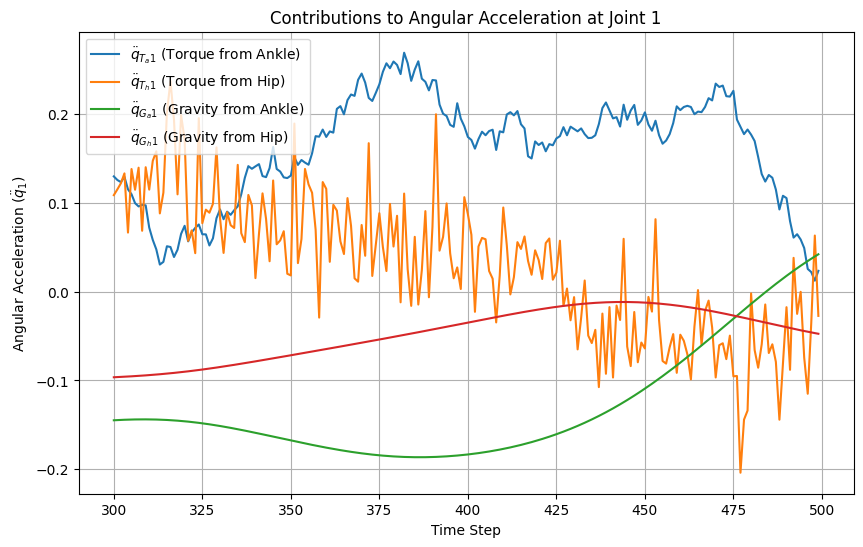

In [98]:
import matplotlib.pyplot as plt

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_Ta1"][300:500], label=r'$\ddot{q}_{T_a1}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_Th1"][300:500], label=r'$\ddot{q}_{T_h1}$ (Torque from Hip)')
plt.plot(sasagawa["ddq_Ga1"][300:500], label=r'$\ddot{q}_{G_a1}$ (Gravity from Ankle)')
plt.plot(sasagawa["ddq_Gh1"][300:500], label=r'$\ddot{q}_{G_h1}$ (Gravity from Hip)')

# Add title and labels
plt.title("Contributions to Angular Acceleration at Joint 1")
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## plot gain to hip

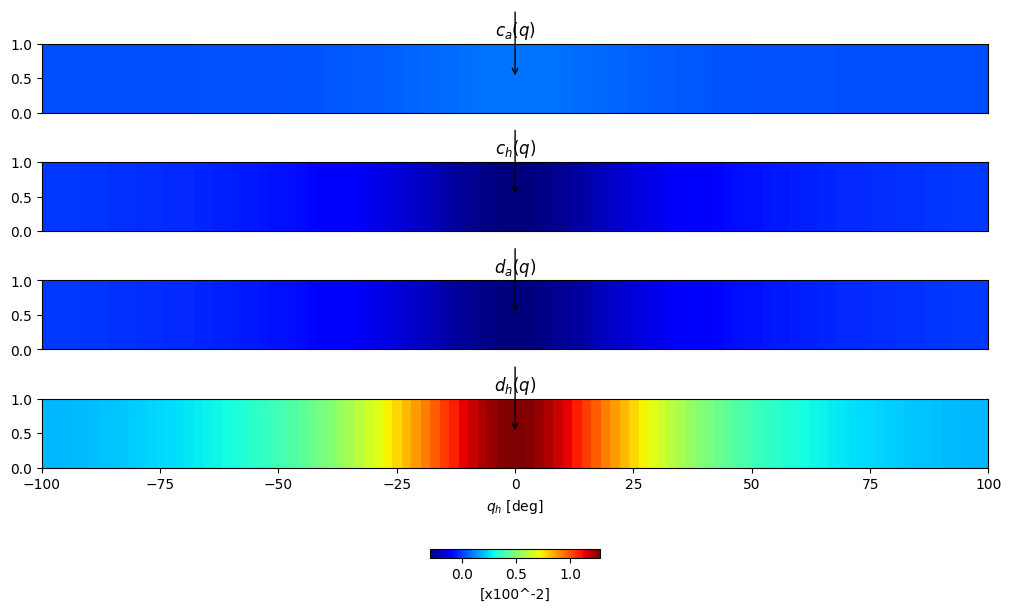

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Given physical parameters
params = {
    'm1': 28.00,   # Mass of the first segment (leg)
    'm2': 53.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.88,    # Length of the second segment (trunk)
    'com1': 0.58,  # Distance to CoM of the first segment
    'com2': 0.32,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Define range of hip joint angles qh (in degrees)
qh_degrees = np.linspace(-100, 100, 100)
qh_rad = np.deg2rad(qh_degrees)

# Preallocate storage for the coefficients
ca_values, ch_values, da_values, dh_values = [], [], [], []

# Compute the coefficients over the range of qh
for qh in qh_rad:
    m1, m2, L1, L2, I1, I2, g = params.values()
    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Inertia matrix elements
    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    # Compute the inertia matrix
    Theta = np.array([
        [a + 2 * b * np.cos(qh), d + b * np.cos(qh)],
        [d + b * np.cos(qh), d]
    ])

    # Compute inverse inertia matrix
    Theta_inv = np.linalg.inv(Theta)

    # Extract coefficients
    ca_values.append(Theta_inv[0, 0])  # Θ22/det(Θ)
    ch_values.append(Theta_inv[0, 1])  # -Θ12/det(Θ)
    da_values.append(Theta_inv[1, 0])  # -Θ21/det(Θ)
    dh_values.append(Theta_inv[1, 1])  # Θ11/det(Θ)

# Convert lists to numpy arrays
ca_values = np.array(ca_values)
ch_values = np.array(ch_values)
da_values = np.array(da_values)
dh_values = np.array(dh_values)

# Determine common color range for uniform plotting
vmin = min(ca_values.min(), ch_values.min(), da_values.min(), dh_values.min())
vmax = max(ca_values.max(), ch_values.max(), da_values.max(), dh_values.max())

# Create the figure
fig, ax = plt.subplots(4, 1, figsize=(10, 6), constrained_layout=True)

# Plot ca(q)
c1 = ax[0].imshow([ca_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[0].set_title(r'$c_a(q)$')
ax[0].set_xticks([])  # Hide x-axis ticks

# Plot ch(q)
c2 = ax[1].imshow([ch_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[1].set_title(r'$c_h(q)$')
ax[1].set_xticks([])

# Plot da(q)
c3 = ax[2].imshow([da_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[2].set_title(r'$d_a(q)$')
ax[2].set_xticks([])

# Plot dh(q)
c4 = ax[3].imshow([dh_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[3].set_title(r'$d_h(q)$')
ax[3].set_xlabel(r'$q_h$ [deg]')

# Add colorbar
cbar = fig.colorbar(c4, ax=ax, orientation='horizontal', fraction=0.02, pad=0.08)
cbar.set_label('[x100^-2]')

# Add arrows to indicate mean value (0 degrees)
for a in ax:
    a.annotate('', xy=(0, 0.5), xytext=(0, 1.5),
               arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

## plot T G

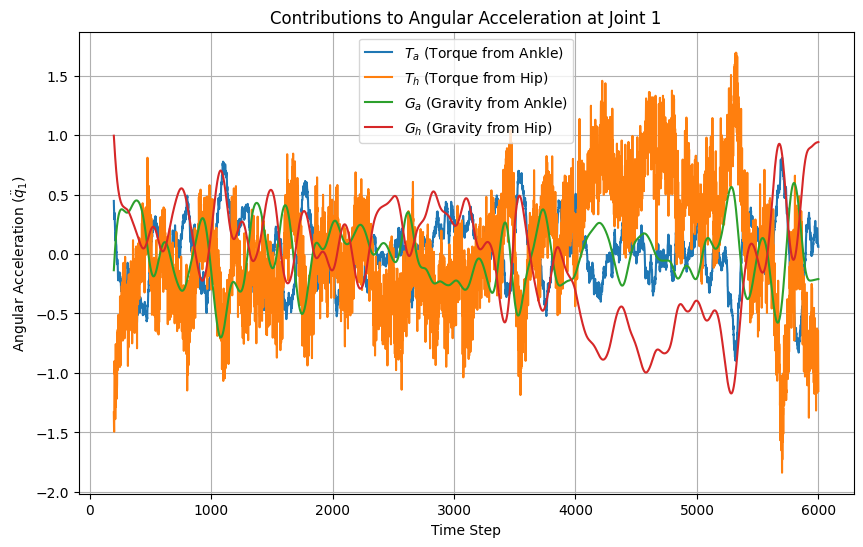

In [76]:
import matplotlib.pyplot as plt

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_Ta2"][200:], label=r'${T_a}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_Th2"][200:], label=r'${T_h}$ (Torque from Hip)')
plt.plot(sasagawa["ddq_Ga2"][200:], label=r'${G_a}$ (Gravity from Ankle)')
plt.plot(sasagawa["ddq_Gh2"][200:], label=r'${G_h}$ (Gravity from Hip)')


# Add title and labels
plt.title("Contributions to Angular Acceleration at Joint 1")
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## plot NET torque

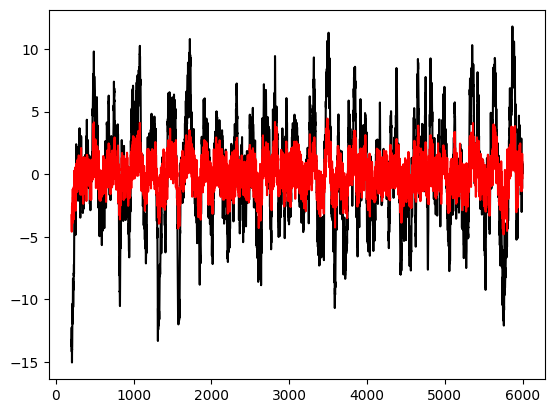

In [77]:
plt.plot(df.index[200:], df['NET_torque1'][200:],color="black")
plt.plot(df.index[200:], df['NET_torque2'][200:],color="r")

In [78]:
def calculate_psd(signal, fs, fmin=0, fmax=2):
    """
    Calculate the PSD and normalize it in the 0-2 Hz range.
    
    Args:
        signal: The input signal (time-domain data).
        fs: Sampling frequency in Hz.
        fmin, fmax: Frequency range for normalization.
    
    Returns:
        freqs: Frequency values.
        psd_normalized: PSD normalized in the 0-2 Hz band.
    """
    freqs, psd = welch(signal, fs=fs, nperseg=1024)  # Welch's method
    idx_band = (freqs >= fmin) & (freqs <= fmax)
    total_power_band = np.sum(psd[idx_band])  # Total power in the 0-2 Hz band
    psd_normalized = psd / total_power_band  # Normalize PSD
    return freqs, psd_normalized

def calculate_mpf(freqs, psd_normalized):
    """
    Calculate the Mean Power Frequency (MPF).
    
    Args:
        freqs: Frequency values.
        psd_normalized: Normalized PSD.
    
    Returns:
        MPF: Mean Power Frequency.
    """
    numerator = np.sum(freqs * psd_normalized)  # Integral of f * P(f)
    denominator = np.sum(psd_normalized)       # Integral of P(f)
    mpf = numerator / denominator
    return mpf


In [79]:
# Example signals (replace with your NETa and NETh data)
net_torque_ankle = df["NET_torque1"]  # Replace with actual NETa data
net_torque_hip = df["NET_torque2"]    # Replace with actual NETh data

# Sampling frequency (replace with actual sampling frequency of your data)
fs = 100  # Example: 100 Hz

# Calculate PSD and MPF for NETa
freqs_ankle, psd_ankle = calculate_psd(net_torque_ankle, fs)
mpf_ankle = calculate_mpf(freqs_ankle, psd_ankle)

# Calculate PSD and MPF for NETh
freqs_hip, psd_hip = calculate_psd(net_torque_hip, fs)
mpf_hip = calculate_mpf(freqs_hip, psd_hip)

# Print results
print(f"MPF for NETa (Ankle): {mpf_ankle:.2f} Hz")
print(f"MPF for NETh (Hip): {mpf_hip:.2f} Hz")


MPF for NETa (Ankle): 1.68 Hz
MPF for NETh (Hip): 9.49 Hz


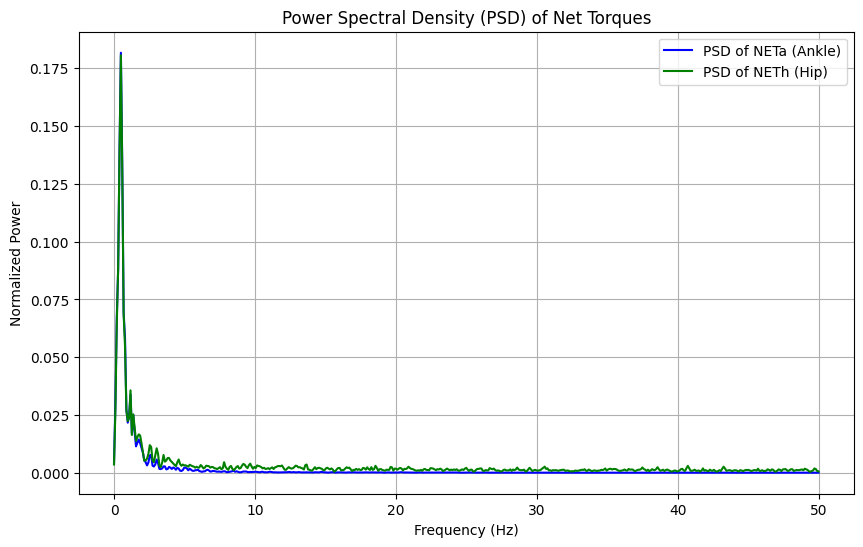

In [80]:
# Plot PSD for NETa and NETh
plt.figure(figsize=(10, 6))
plt.plot(freqs_ankle, psd_ankle, label='PSD of NETa (Ankle)', color='blue')
plt.plot(freqs_hip, psd_hip, label='PSD of NETh (Hip)', color='green')

# Add plot details
plt.title("Power Spectral Density (PSD) of Net Torques")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Power")
plt.legend()
plt.grid(True)
plt.show()


## plot effects of two NET torques

In [81]:
def calculate_rms(data):
    return np.sqrt(np.mean(np.square(data)))

# Update lists from the DataFrame
ddq_NETa_ankle_list = sasagawa['ddq_NETa1'][:500].tolist()  # NETa contribution to ankle
ddq_NETa_hip_list = sasagawa['ddq_NETa2'][:500].tolist()    # NETa contribution to hip
ddq_NETh_ankle_list = sasagawa['ddq_NETh1'][:500].tolist()  # NETh contribution to ankle
ddq_NETh_hip_list = sasagawa['ddq_NETh2'][:500].tolist()    # NETh contribution to hip

# Calculate RMS for each contribution
rms_NETa_ankle = calculate_rms(ddq_NETa_ankle_list)
rms_NETh_ankle = calculate_rms(ddq_NETh_ankle_list)
rms_NETa_hip = calculate_rms(ddq_NETa_hip_list)
rms_NETh_hip = calculate_rms(ddq_NETh_hip_list)

# Print RMS results
print(f"RMS of q̈aNETa: {rms_NETa_ankle:.2f} ± {np.std(ddq_NETa_ankle_list) / np.sqrt(len(ddq_NETa_ankle_list)):.2f}°/s²")
print(f"RMS of q̈aNETh: {rms_NETh_ankle:.2f} ± {np.std(ddq_NETh_ankle_list) / np.sqrt(len(ddq_NETh_ankle_list)):.2f}°/s²")
print(f"RMS of q̈hNETa: {rms_NETa_hip:.2f} ± {np.std(ddq_NETa_hip_list) / np.sqrt(len(ddq_NETa_hip_list)):.2f}°/s²")
print(f"RMS of q̈hNETh: {rms_NETh_hip:.2f} ± {np.std(ddq_NETh_hip_list) / np.sqrt(len(ddq_NETh_hip_list)):.2f}°/s²")


RMS of q̈aNETa: 0.32 ± 0.01°/s²
RMS of q̈aNETh: 0.21 ± 0.01°/s²
RMS of q̈hNETa: 0.76 ± 0.03°/s²
RMS of q̈hNETh: 0.84 ± 0.04°/s²


In [87]:
def normalized_cross_correlation(x, y, fs):
    """
    Calculate the normalized cross-correlation between two signals.

    Args:
        x: First signal (array-like).
        y: Second signal (array-like).
        fs: Sampling frequency (Hz).

    Returns:
        lags: Array of time lags (in seconds).
        Rxy: Normalized cross-correlation values.
    """
    n = len(x)
    
    # Compute cross-correlation
    cross_corr = np.correlate(x - np.mean(x), y - np.mean(y), mode='full')
    
    # Normalize cross-correlation
    normalization_factor = np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((y - np.mean(y))**2))
    Rxy = cross_corr / normalization_factor
    
    # Calculate lags (in seconds)
    lags = np.arange(-n + 1, n) / fs
    return lags, Rxy


In [113]:
# Sampling frequency (replace with actual value)
fs = 100  # Example: 100 Hz

# Signals (replace with actual DataFrame columns)
x = sasagawa['ddq_NETa1'][:6000].values  # Ankle torque contribution
y = sasagawa['ddq_NETh1'][:6000].values  # Hip torque contribution

# Compute normalized cross-correlation
lags, Rxy = normalized_cross_correlation(x, y, fs)

# Find the maximum correlation value and corresponding lag
max_corr = np.min(Rxy)
max_lag = lags[np.argmin(Rxy)]

print(f"Maximum Correlation: {max_corr:.3f}")
print(f"Lag at Maximum Correlation: {max_lag:.3f} s")


Maximum Correlation: -0.798
Lag at Maximum Correlation: 0.000 s


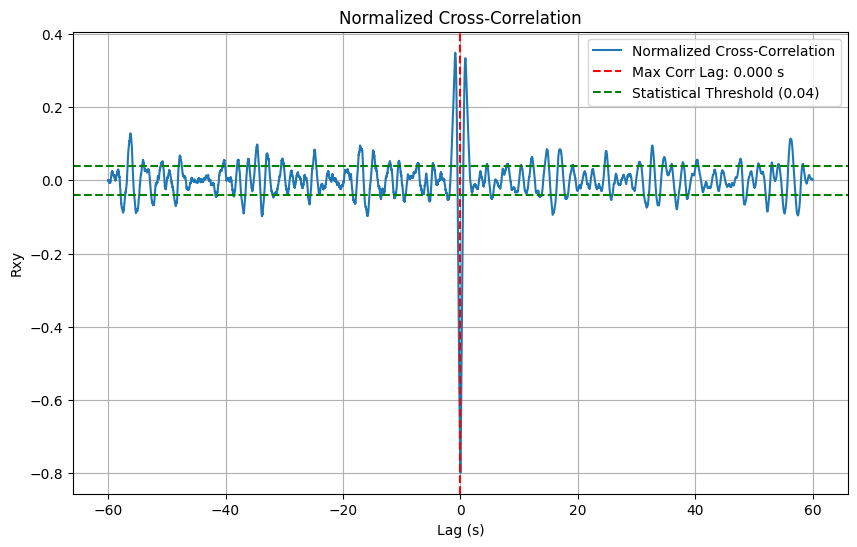

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lags, Rxy, label='Normalized Cross-Correlation')
plt.axvline(x=max_lag, color='red', linestyle='--', label=f'Max Corr Lag: {max_lag:.3f} s')
plt.axhline(y=0.04, color='green', linestyle='--', label='Statistical Threshold (0.04)')
plt.axhline(y=-0.04, color='green', linestyle='--')
plt.title("Normalized Cross-Correlation")
plt.xlabel("Lag (s)")
plt.ylabel("Rxy")
plt.legend()
plt.grid(True)
plt.show()


■ 最も負の相関係数: -0.804
   ⇒ そのラグ = 0.010 s, p = 0
■ ラグ0での相関係数: -0.798, p = 0


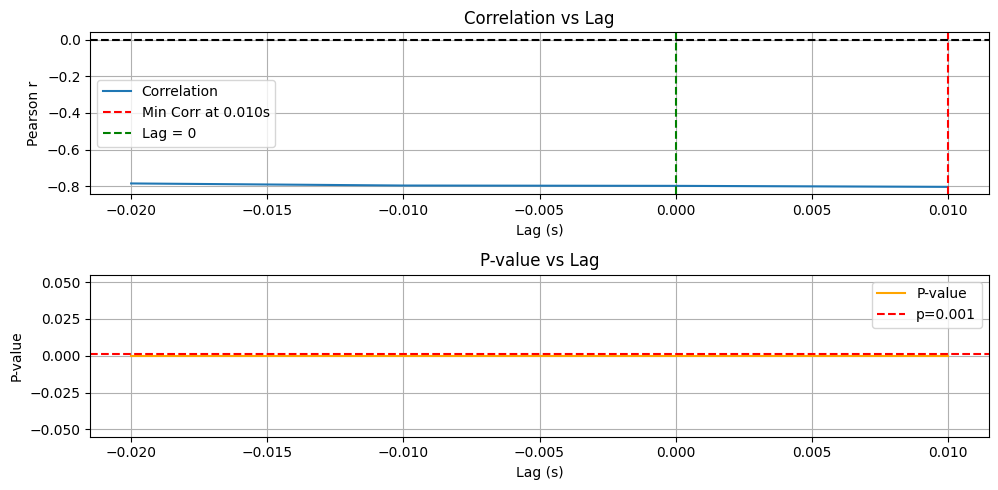

In [124]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def compute_correlation_with_lags(signal1, signal2, fs):
    """
    指定した2つの時系列信号の相関係数と P値を、-0.02s ~ +0.01s の範囲で算出する。
    1サンプルあたりの長さは 1/fs で計算。
    """
    # ラグのサンプル数（-0.02秒～+0.01秒）
    lag_samples_min = int(np.floor(-0.02 * fs))  # -0.02s → 例えば fs=100 なら -2 サンプル
    lag_samples_max = int(np.ceil( 0.01 * fs))   # +0.01s → 例えば fs=100 なら +1 サンプル
    
    # ラグ配列（秒単位）
    lags = np.arange(lag_samples_min, lag_samples_max + 1) / fs
    
    correlations = []
    p_values = []
    
    # 相関・p値を計算
    for lag in range(lag_samples_min, lag_samples_max + 1):
        if lag < 0:
            # signal2を左に |lag|サンプルずらす → 前方に zero-padding
            shifted_signal2 = np.pad(signal2[:lag], (abs(lag), 0), mode='constant')
            shifted_signal1 = signal1
        elif lag > 0:
            # signal1を左に lag サンプルずらす → 後方に zero-padding
            shifted_signal1 = np.pad(signal1[lag:], (0, lag), mode='constant')
            shifted_signal2 = signal2
        else:
            # lag=0 の場合はそのまま
            shifted_signal1 = signal1
            shifted_signal2 = signal2
        
        r, p = pearsonr(shifted_signal1, shifted_signal2)
        correlations.append(r)
        p_values.append(p)
    
    return np.array(correlations), np.array(p_values), lags

# -----------------------------
# サンプルデータ（適宜置き換えてください）
# 例：sasagawaという辞書に格納されている想定
signal1 = sasagawa['ddq_NETa1'][:6000]
signal2 = sasagawa['ddq_NETh1'][:6000]
fs = 100  # サンプリング周波数(Hz)
# -----------------------------

# 相関係数とP値の算出
correlations, p_values, lags = compute_correlation_with_lags(signal1, signal2, fs)

# 1) 相関係数が最小（最も負）になる箇所を探す
min_corr_value = np.min(correlations)
min_corr_index = np.argmin(correlations)
min_corr_lag   = lags[min_corr_index]
min_corr_p     = p_values[min_corr_index]

# 2) ラグが 0 のときの相関係数と p値を調べる
#    lags配列にちょうど0が含まれているはずなので検索
zero_lag_index = np.where(lags == 0)[0]
if len(zero_lag_index) > 0:
    zero_lag_index = zero_lag_index[0]
    zero_corr_value = correlations[zero_lag_index]
    zero_corr_p     = p_values[zero_lag_index]
else:
    # 万一含まれていない場合のための例外処理（基本的に起きない想定）
    zero_corr_value = None
    zero_corr_p     = None

# 結果を表示
print(f"■ 最も負の相関係数: {min_corr_value:.3f}")
print(f"   ⇒ そのラグ = {min_corr_lag:.3f} s, p = {min_corr_p:.4g}")
if zero_corr_value is not None:
    print(f"■ ラグ0での相関係数: {zero_corr_value:.3f}, p = {zero_corr_p:.4g}")
else:
    print("ラグ0が解析範囲内にありません")

# 以下、参考としてプロットを行う場合
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(lags, correlations, label='Correlation')
plt.axvline(min_corr_lag, color='red', linestyle='--',
            label=f'Min Corr at {min_corr_lag:.3f}s')
if zero_corr_value is not None:
    plt.axvline(0, color='green', linestyle='--', label='Lag = 0')
plt.axhline(0, color='black', linestyle='--')
plt.title('Correlation vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('Pearson r')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(lags, p_values, label='P-value', color='orange')
plt.axhline(0.001, color='red', linestyle='--', label='p=0.001')
plt.title('P-value vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


■ 最も負の相関係数: -0.804
   ⇒ そのラグ = 0.010 s, p = 0
■ ラグ0での相関係数: -0.798, p = 0


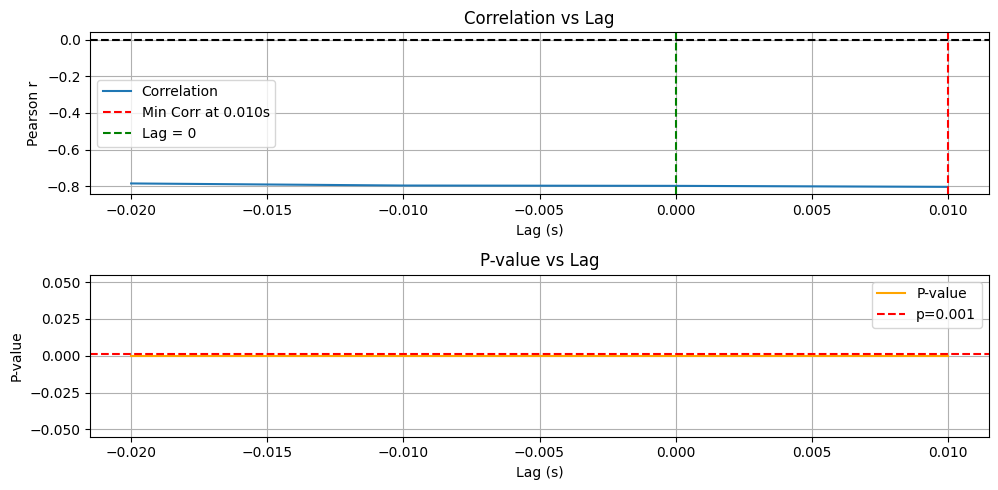

In [127]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def compute_correlation_with_lags(signal1, signal2, fs):
    """
    指定した2つの時系列信号の相関係数と P値を、-0.02s ~ +0.01s の範囲で算出する。
    1サンプルあたりの長さは 1/fs で計算。
    """
    # ラグのサンプル数（-0.02秒～+0.01秒）
    lag_samples_min = int(np.floor(-0.02 * fs))  # -0.02s → 例えば fs=100 なら -2 サンプル
    lag_samples_max = int(np.ceil( 0.01 * fs))   # +0.01s → 例えば fs=100 なら +1 サンプル
    
    # ラグ配列（秒単位）
    lags = np.arange(lag_samples_min, lag_samples_max + 1) / fs
    
    correlations = []
    p_values = []
    
    # 相関・p値を計算
    for lag in range(lag_samples_min, lag_samples_max + 1):
        if lag < 0:
            # signal2を左に |lag|サンプルずらす → 前方に zero-padding
            shifted_signal2 = np.pad(signal2[:lag], (abs(lag), 0), mode='constant')
            shifted_signal1 = signal1
        elif lag > 0:
            # signal1を左に lag サンプルずらす → 後方に zero-padding
            shifted_signal1 = np.pad(signal1[lag:], (0, lag), mode='constant')
            shifted_signal2 = signal2
        else:
            # lag=0 の場合はそのまま
            shifted_signal1 = signal1
            shifted_signal2 = signal2
        
        r, p = pearsonr(shifted_signal1, shifted_signal2)
        correlations.append(r)
        p_values.append(p)
    
    return np.array(correlations), np.array(p_values), lags

# -----------------------------
# サンプルデータ（適宜置き換えてください）
# 例：sasagawaという辞書に格納されている想定
signal1 = sasagawa['ddq_NETa2'][:6000]
signal2 = sasagawa['ddq_NETh2'][:6000]
fs = 100  # サンプリング周波数(Hz)
# -----------------------------

# 相関係数とP値の算出
correlations, p_values, lags = compute_correlation_with_lags(signal1, signal2, fs)

# 1) 相関係数が最小（最も負）になる箇所を探す
min_corr_value = np.min(correlations)
min_corr_index = np.argmin(correlations)
min_corr_lag   = lags[min_corr_index]
min_corr_p     = p_values[min_corr_index]

# 2) ラグが 0 のときの相関係数と p値を調べる
#    lags配列にちょうど0が含まれているはずなので検索
zero_lag_index = np.where(lags == 0)[0]
if len(zero_lag_index) > 0:
    zero_lag_index = zero_lag_index[0]
    zero_corr_value = correlations[zero_lag_index]
    zero_corr_p     = p_values[zero_lag_index]
else:
    # 万一含まれていない場合のための例外処理（基本的に起きない想定）
    zero_corr_value = None
    zero_corr_p     = None

# 結果を表示
print(f"■ 最も負の相関係数: {min_corr_value:.3f}")
print(f"   ⇒ そのラグ = {min_corr_lag:.3f} s, p = {min_corr_p:.4g}")
if zero_corr_value is not None:
    print(f"■ ラグ0での相関係数: {zero_corr_value:.3f}, p = {zero_corr_p:.4g}")
else:
    print("ラグ0が解析範囲内にありません")

# 以下、参考としてプロットを行う場合
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(lags, correlations, label='Correlation')
plt.axvline(min_corr_lag, color='red', linestyle='--',
            label=f'Min Corr at {min_corr_lag:.3f}s')
if zero_corr_value is not None:
    plt.axvline(0, color='green', linestyle='--', label='Lag = 0')
plt.axhline(0, color='black', linestyle='--')
plt.title('Correlation vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('Pearson r')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(lags, p_values, label='P-value', color='orange')
plt.axhline(0.001, color='red', linestyle='--', label='p=0.001')
plt.title('P-value vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


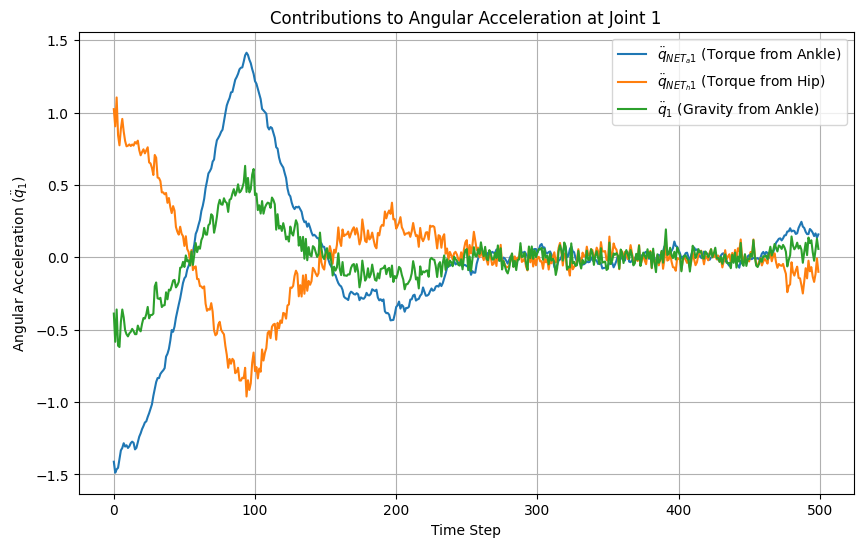

In [293]:
import matplotlib.pyplot as plt

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_NETa1"][:500], label=r'$\ddot{q}_{NET_a1}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_NETh1"][:500], label=r'$\ddot{q}_{NET_h1}$ (Torque from Hip)')
plt.plot(sasagawa["ddq1"][:500], label=r'$\ddot{q}_1$ (Gravity from Ankle)')

# Add title and labels
plt.title("Contributions to Angular Acceleration at Joint 1")
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


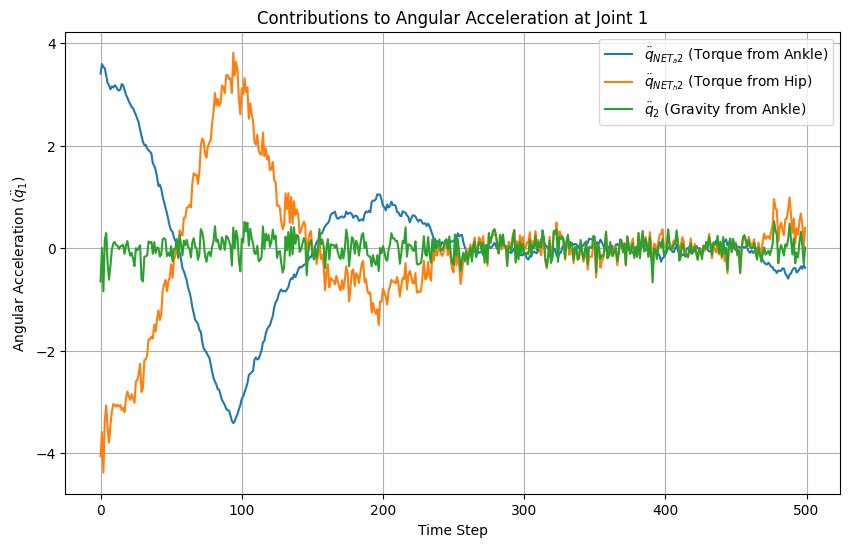

In [296]:
import matplotlib.pyplot as plt

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_NETa2"][:500], label=r'$\ddot{q}_{NET_a2}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_NETh2"][:500], label=r'$\ddot{q}_{NET_h2}$ (Torque from Hip)')
plt.plot(sasagawa["ddq2"][:500], label=r'$\ddot{q}_2$ (Gravity from Ankle)')

# Add title and labels
plt.title("Contributions to Angular Acceleration at Joint 1")
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


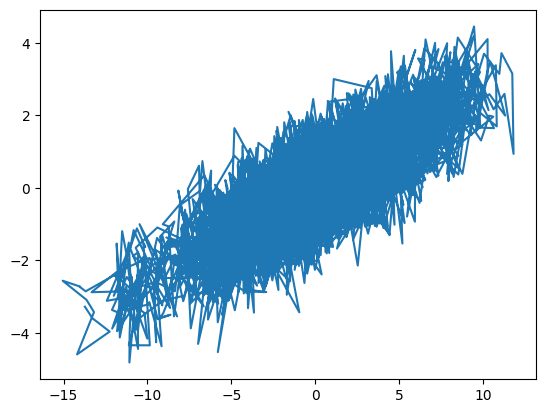

In [274]:
# plt.plot(df.index[200:], df['NET_torque1'][200:],color="black")/
plt.plot(df['NET_torque1'][200:], df['NET_torque2'][200:])

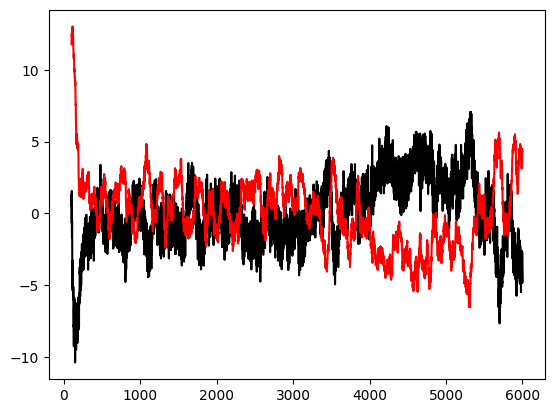

In [261]:
plt.plot(df.index[100:], df['u2_s'][100:], label='u1_s',color="black")
plt.plot(df.index[100:], df['G2_s_true'][100:], label='u1_l',color="r")

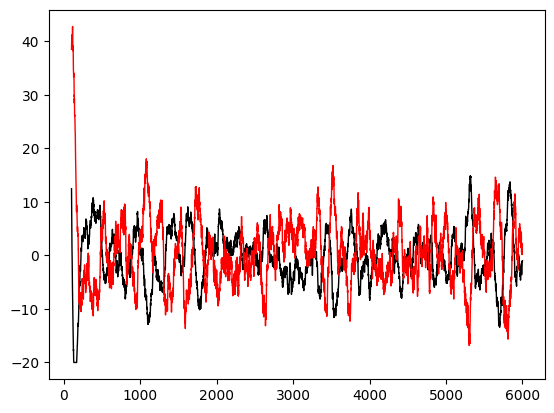

In [262]:
plt.plot(df.index[100:], df['u1_s'][100:], label='u1_s',color="black",linewidth=1)
plt.plot(df.index[100:], df['G1_s_true'][100:], label='u1_l',color="r",linewidth=1)

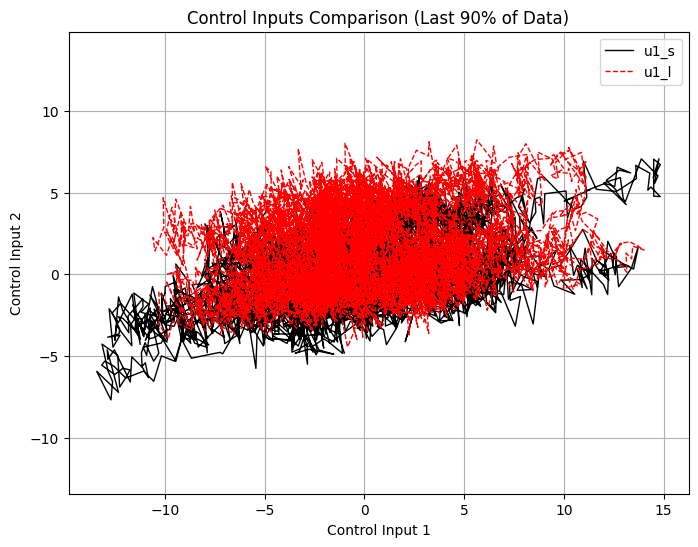

In [197]:
import matplotlib.pyplot as plt
import numpy as np

# データフレーム df が存在することを確認してください
if 'df' in locals():
    # データの後半90%を取得
    start_index = int(len(df) * 0.1)  # 先頭10%をスキップ
    df_subset = df.iloc[start_index:]

    # データの取得
    u1_s = df_subset['u1_s'].values
    u2_s = df_subset['u2_s'].values
    u1_l = df_subset['u1_l'].values
    u2_l = df_subset['u2_l'].values

    # すべてのデータを結合して90%範囲を計算
    all_data = np.concatenate([u1_s, u2_s, u1_l, u2_l])
    percentile_5 = np.percentile(all_data, 0)
    percentile_95 = np.percentile(all_data, 100)

    # プロット
    plt.figure(figsize=(8, 6))
    plt.plot(u1_s, u2_s, label='u1_s', color="black", linewidth=1)
    plt.plot(u1_l, u2_l, label='u1_l', linestyle="--", color="r", linewidth=1)

    # y軸の範囲を設定（全体の90%のデータ範囲）
    plt.ylim(percentile_5, percentile_95)

    # ラベルと凡例
    plt.xlabel('Control Input 1')
    plt.ylabel('Control Input 2')
    plt.legend()
    plt.title('Control Inputs Comparison (Last 90% of Data)')

    # グリッド表示
    plt.grid(True)

    # グラフの表示
    plt.show()
else:
    print("データフレーム 'df' が存在しません。データを提供してください。")


Text(0, 0.5, 'u2(N.m)')

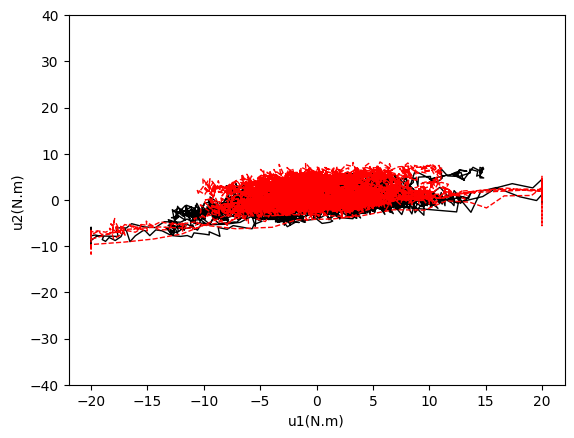

In [198]:
plt.plot(df['u1_s'], df['u2_s'], label='u1_s',color="black",linewidth=1)
plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
plt.ylim(-40, 40)

plt.xlabel('u1(N.m)')
plt.ylabel('u2(N.m)')

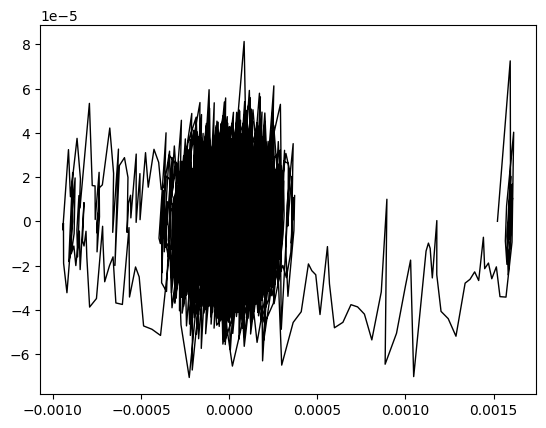

In [199]:
plt.plot(df['com_x_s'], df['dcom_x_s'], label='u1_s',color="black",linewidth=1)


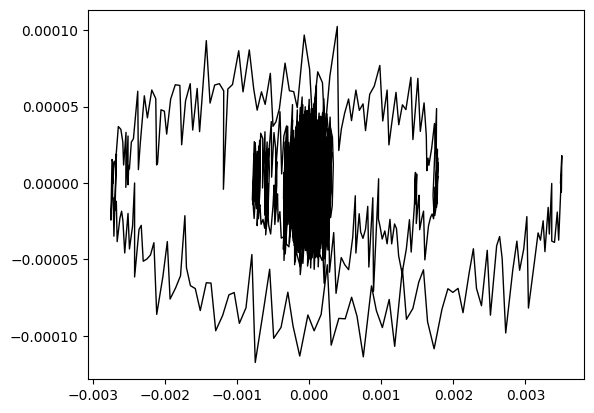

In [200]:
plt.plot(df['com_x_l'], df['dcom_x_l'], label='u1_s',color="black",linewidth=1)

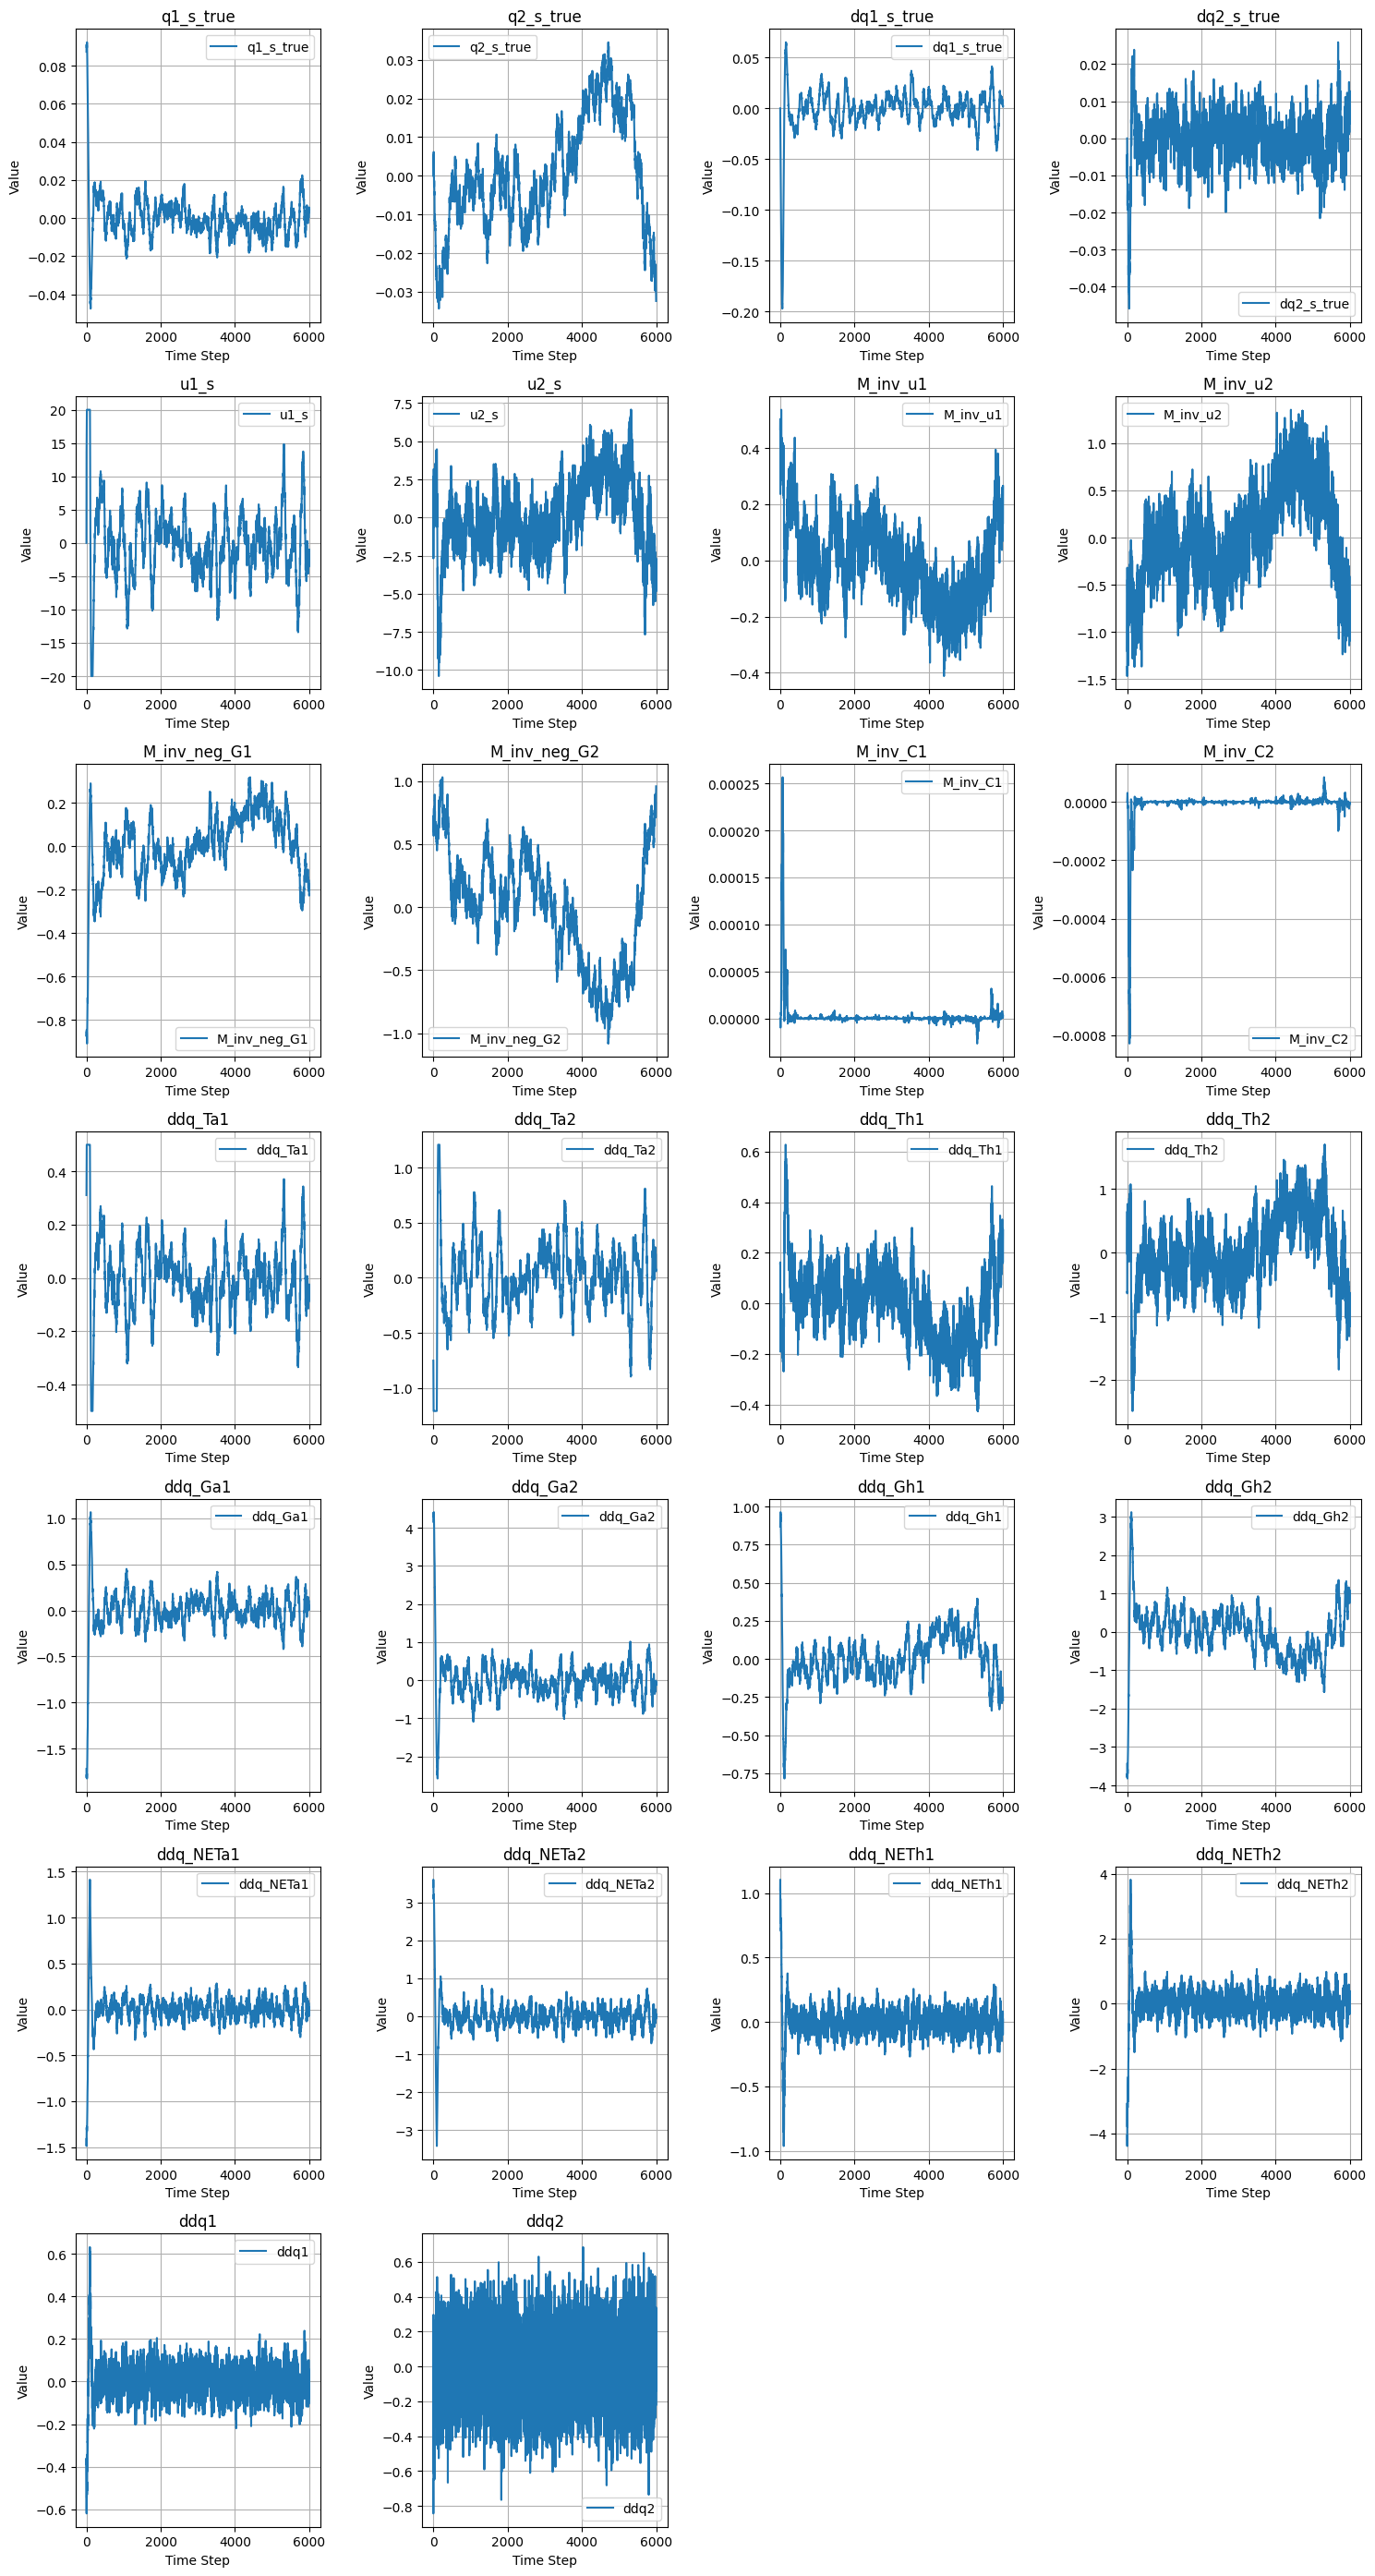

In [230]:
# データフレームのカラム数を取得
num_columns = len(sasagawa.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(sasagawa.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(sasagawa[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()

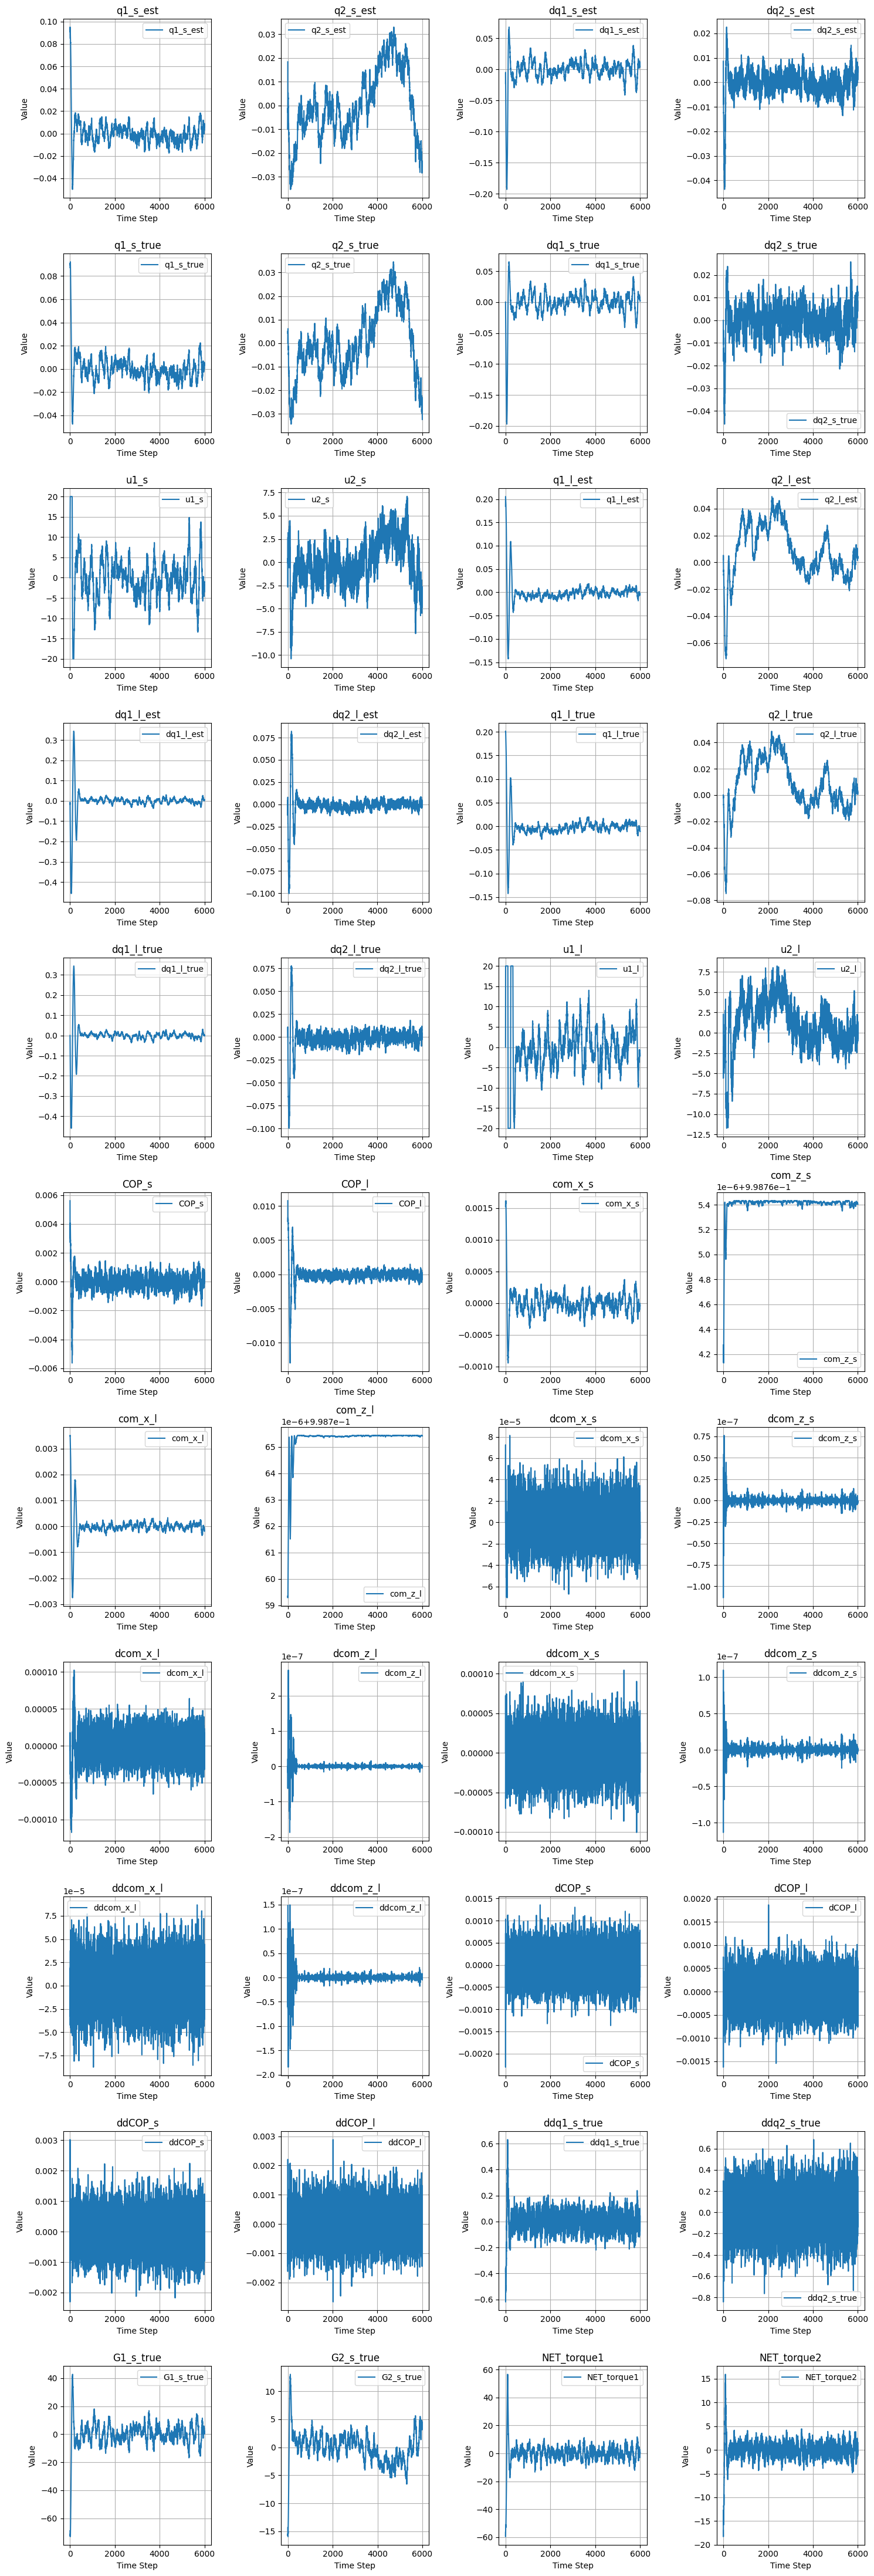

In [229]:
# データフレームのカラム数を取得
num_columns = len(df.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(df[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()